Directory Information

In [177]:
out_dir = '/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/analyses/enrollment'

In [178]:
# Paths to the uploaded CSV files
csv_paths = [
    '/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/memory_extraction_data/calvin/calvin_enrollment_master_list.csv',
    '/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/memory_extraction_data/gpt_4/gpt_4_enrollment_master_list.csv'
]

Specify Columns of Spreadhseet to Assess

In [179]:
binary_columns = ["Inclusion"]

Preprocess Data

In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import numpy as np

import pandas as pd

class CSVAligner:
    def __init__(self, csv_paths, align_on='Title', nanhandle='zero'):
        self.csv_paths = csv_paths
        self.align_on = align_on
        self.nanhandle = nanhandle
        self.dataframes = [pd.read_csv(path, encoding='ISO-8859-1') for path in csv_paths]
        self.aligned_data = self.align_csvs()

    def align_csvs(self):
        # Find the intersection of titles across all CSVs
        common_titles = set.intersection(*(set(df[self.align_on].unique()) for df in self.dataframes))
        print(f"Common titles count: {len(common_titles)}")

        # Create new dataframes with only the rows that have the common titles
        aligned_data = []
        for df in self.dataframes:
            # Filter rows by the common titles and remove duplicates
            aligned_df = df[df[self.align_on].isin(common_titles)].drop_duplicates(subset=[self.align_on])
            # Backfill NaNs if the option is set
            if self.nanhandle=='bfill':
                aligned_df = aligned_df.bfill(axis='rows')
            elif self.nanhandle=='zero':
                aligned_df = aligned_df.fillna(0)
            # Sort by title to ensure order is consistent
            aligned_df.sort_values(by=self.align_on, inplace=True)
            # Reset index for consistency
            aligned_df.reset_index(drop=True, inplace=True)
            aligned_data.append(aligned_df)
            print(f"Aligned dataframe rows: {aligned_df.shape[0]}")

        # Verify that all dataframes have the same order of titles
        for i in range(len(aligned_data) - 1):
            assert (aligned_data[i][self.align_on].values == aligned_data[i + 1][self.align_on].values).all(), "Row mismatch"

        return aligned_data


In [181]:
aligner = CSVAligner(csv_paths)

Common titles count: 100
Aligned dataframe rows: 100
Aligned dataframe rows: 100


Plot Cohen's Kappa

In [182]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Class for computing and plotting Cohen's Kappa
class CohensKappaPlotter:
    def __init__(self, aligned_data, gold_standard_index=0):
        self.aligned_data = aligned_data
        self.gold_standard_df = self.aligned_data[gold_standard_index]
        self.comparator_dfs = self.aligned_data[1:]

    def compute_kappa(self, columns):
        kappa_scores = []
        for idx, df in enumerate(self.comparator_dfs):
            for column in columns:
                if column not in self.gold_standard_df.columns:
                    print(f"Column {column} not found in gold standard dataframe.")
                    continue
                if column not in df.columns:
                    print(f"Column {column} not found in comparator dataframe for GPT {4-idx}.")
                    continue

                # Check if the column is binary
                if set(self.gold_standard_df[column].unique()).issubset({0, 1}) and set(df[column].unique()).issubset({0, 1}):
                    kappa = cohen_kappa_score(self.gold_standard_df[column], df[column])
                    kappa_scores.append((column, kappa, f'GPT {4-idx}'))
                else:
                    print(f"Column {column} is not binary in one or both dataframes for GPT {4-idx}.")
        return kappa_scores



    def kappa_confidence_interval(self, kappa, n):
        # Standard error
        se = np.sqrt((2 * (1 - kappa)) / n)
        return kappa - 1.96 * se, kappa + 1.96 * se

    def plot_kappa(self, kappa_scores, save_dir):
        # Define the color map for the comparators
        color_map = ['purple', 'green']

        # Create a DataFrame for plotting
        kappa_df = pd.DataFrame(kappa_scores, columns=['Column', 'Kappa', 'Comparator'])
        
        plt.figure(figsize=(12, 6))
        sns.set_theme(style="whitegrid")
        
        # Use Seaborn to plot the kappa scores with the 'Comparator' column defining the hue
        ax = sns.barplot(x='Column', y='Kappa', hue='Comparator', data=kappa_df, palette=color_map)
        ax.set(ylim=(0, 1))
        plt.xticks(rotation=45)
        
        # Define the directory path for saving
        cohens_kappa_dir = os.path.join(save_dir, "cohens_kappa")
        os.makedirs(cohens_kappa_dir, exist_ok=True)  # Ensure the directory exists
        
        # Iterate over each comparator to save individual plots
        for comparator in kappa_df['Comparator'].unique():
            comparator_scores = kappa_df[kappa_df['Comparator'] == comparator]
            
            plt.figure(figsize=(12, 6))
            sns.barplot(x='Column', y='Kappa', data=comparator_scores, color=color_map[int(comparator[-1])-3])
            plt.ylim(0, 1)
            plt.xticks(rotation=45)
            plt.title(f'Cohen\'s Kappa Scores - {comparator}')
            
            # Define the file names
            file_name_png = f"{comparator}_cohens_kappa.png"
            file_name_svg = f"{comparator}_cohens_kappa.svg"

            # Construct the full file paths
            path_png = os.path.join(cohens_kappa_dir, file_name_png)
            path_svg = os.path.join(cohens_kappa_dir, file_name_svg)

            # Save the plots as PNG and SVG
            plt.savefig(path_png, format='png', bbox_inches='tight')
            plt.savefig(path_svg, format='svg', bbox_inches='tight')

            # Close the plot to avoid overlapping figures
            plt.close()


[('Inclusion', 0.96684350132626, 'GPT 4')]


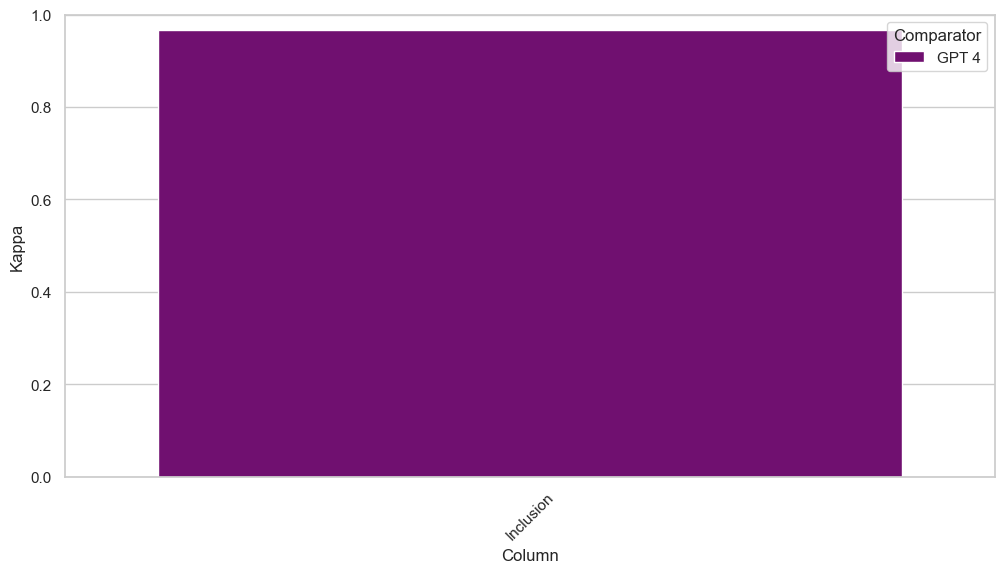

In [183]:
# Initialize the plotter with your aligned data
kappa_plotter = CohensKappaPlotter(aligner.aligned_data)

# Compute kappa scores for these columns
kappa_scores = kappa_plotter.compute_kappa(binary_columns)
print(kappa_scores)

# Plot and save the kappa scores
kappa_plotter.plot_kappa(kappa_scores, save_dir=out_dir)


Z Proportion Test

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.stats.proportion import proportions_ztest

class ZProportionPlotter:
    def __init__(self, aligned_data, gold_standard_index=0):
        self.aligned_data = aligned_data
        self.gold_standard_df = self.aligned_data[gold_standard_index]
        self.comparator_dfs = self.aligned_data[1:]

    def compute_z_proportions(self, columns):
        z_scores = []
        for column in columns:
            for idx, df in enumerate(self.comparator_dfs):
                count = np.array([
                    (self.gold_standard_df[column] == df[column]).sum(),
                    (self.gold_standard_df[column] != df[column]).sum()
                ])
                nobs = np.array([len(self.gold_standard_df[column]), len(df[column])])
                stat, pval = proportions_ztest(count=count, nobs=nobs, value=0)
                z_scores.append((column, stat, idx))
        return z_scores, pval

    def plot_z_scores(self, z_scores, save_dir):
        # Convert z_scores to a DataFrame for easier plotting
        z_scores_df = pd.DataFrame(z_scores, columns=['Column', 'Z-score', 'Comparator Index'])

        # Define a color map for the comparators
        color_map = {0: 'purple', 1: 'green'}

        # Plot and save a bar plot for each column
        for column in z_scores_df['Column'].unique():
            plt.figure(figsize=(10, 6))
            sns.set_theme(style="whitegrid")
            column_data = z_scores_df[z_scores_df['Column'] == column]
            ax = sns.barplot(
                x='Comparator Index', 
                y='Z-score', 
                data=column_data, 
                palette=[color_map.get(x) for x in column_data['Comparator Index']]
            )
            ax.set(ylim=(-3, 3))  # Z-scores typically range from -3 to 3
            ax.set_title(f'Z-scores for "{column}"')
            plt.xticks(ticks=ax.get_xticks(), labels=['GPT-4', 'GPT-3'])  # Set ticks and labels
            plt.tight_layout()  # Adjust the plot

            # Define the directory path for saving
            z_proportion_test_dir = os.path.join(save_dir, "z_proportion_test", column)
            os.makedirs(z_proportion_test_dir, exist_ok=True)  # Ensure the directory exists

            # Define the file names
            file_name_png = f"{column}_z_scores.png"
            file_name_svg = f"{column}_z_scores.svg"

            # Construct the full file paths
            path_png = os.path.join(z_proportion_test_dir, file_name_png)
            path_svg = os.path.join(z_proportion_test_dir, file_name_svg)

            # Save the plots as PNG and SVG
            plt.savefig(path_png, format='png', bbox_inches='tight')
            plt.savefig(path_svg, format='svg', bbox_inches='tight')

            # Close the plot to avoid overlapping figures
            plt.close()

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

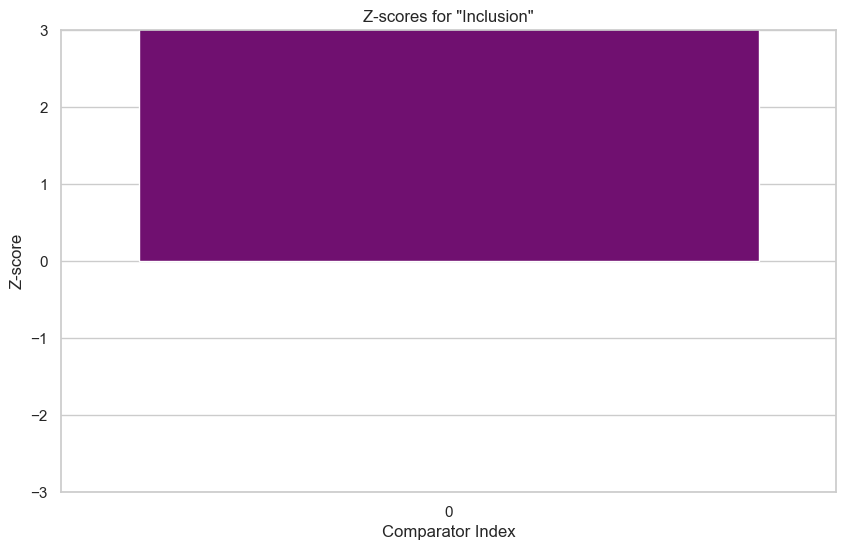

In [185]:
z_plotter = ZProportionPlotter(aligner.aligned_data)
z_scores, pvals = z_plotter.compute_z_proportions(binary_columns)
z_plotter.plot_z_scores(z_scores, save_dir=out_dir)

pvals

Performance Metrics

In [186]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import matplotlib.pyplot as plt
from math import pi
import os

class PerformanceMetricsPlotter:
    def __init__(self, aligned_data, gold_standard_index=0):
        self.aligned_data = aligned_data
        self.gold_standard_df = self.aligned_data[gold_standard_index]
        self.comparator_dfs = self.aligned_data[1:]

    def calculate_metrics(self, column):
        # Calculate metrics for a single column
        metrics = []
        for df in self.comparator_dfs:
            tn, fp, fn, tp = confusion_matrix(self.gold_standard_df[column], df[column], labels=[0, 1]).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
            npv = tn / (tn + fn) if (tn + fn) != 0 else 0
            acc = accuracy_score(self.gold_standard_df[column], df[column])
            precision, recall, f1, _ = precision_recall_fscore_support(self.gold_standard_df[column], df[column], average='binary')
            metrics.append({
                'sensitivity': sensitivity,
                'specificity': specificity,
                'ppv': ppv,
                'npv': npv,
                'f1': f1,
                'accuracy': acc
            })
        return metrics
    
    def plot_confusion_matrix(self, column, save_dir):
        # Iterate over each comparator dataframe
        for idx, df in enumerate(self.comparator_dfs):
            # Compute the confusion matrix
            cm = confusion_matrix(self.gold_standard_df[column], df[column], labels=[0, 1])
            # Normalize the confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #<------ISSUE IS THAT I AM NOT ENTIRELY COMFORTABLE THIS IS NORMALIZING PROPOERLY

            # Plot the normalized confusion matrix as a heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                        xticklabels=['False', 'True'], yticklabels=['False', 'True'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix for "{column}" - GPT {4-idx}')

            # Define the file names
            file_name_png = f"{column}_confusion_matrix_GPT{4-idx}.png"
            file_name_svg = f"{column}_confusion_matrix_GPT{4-idx}.svg"

            # Construct the directory path for confusion matrices
            confusion_matrix_dir = os.path.join(save_dir, "confusion_matrix")
            os.makedirs(confusion_matrix_dir, exist_ok=True)  # Ensure the directory exists

            # Construct the full file paths
            path_png = os.path.join(confusion_matrix_dir, file_name_png)
            path_svg = os.path.join(confusion_matrix_dir, file_name_svg)

            # Save the plots as PNG and SVG
            plt.savefig(path_png, format='png', bbox_inches='tight')
            plt.savefig(path_svg, format='svg', bbox_inches='tight')

            # Close the plot to avoid overlapping figures
            plt.close()



    def plot_radar(self, metrics_data, column, save_dir):
        # Number of variables we're plotting.
        categories = list(metrics_data[0].keys())
        N = len(categories)

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # Initialise the radar plot
        ax = plt.subplot(111, polar=True)

        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], categories)

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
        plt.ylim(0,1)

        # Plot each individual = each line of the data
        color_map = ['purple', 'green']  # Define your colors
        for idx, data in enumerate(metrics_data):
            values = list(data.values())
            values += values[:1]
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'GPT {4-idx}', color=color_map[idx])


        # Add a legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

        # Add a title
        plt.title(f'Metrics for "{column}"', size=20, color='black', y=1.1)
        
        # Define the subdirectory for radar plots within the main save directory
        radar_plots_subdir = "radar_plots"
        os.makedirs(os.path.join(save_dir, radar_plots_subdir), exist_ok=True)
        
        # Construct the file paths
        file_name_png = f"{column}.png"
        file_name_svg = f"{column}.svg"
        path_png = os.path.join(save_dir, radar_plots_subdir, file_name_png)
        path_svg = os.path.join(save_dir, radar_plots_subdir, file_name_svg)

        # Save the files
        plt.savefig(path_png, format='png')
        plt.savefig(path_svg, format='svg')

        # Show the plot
        plt.show()



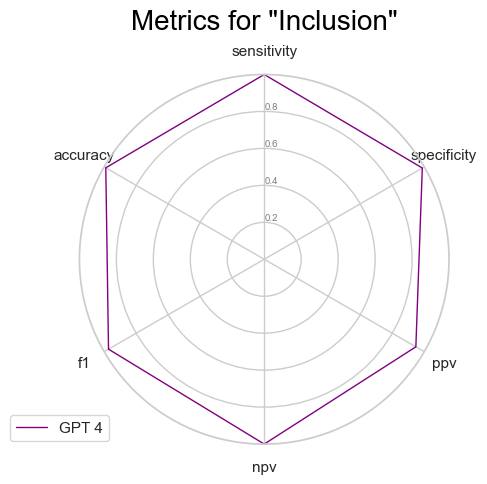

In [187]:
# Assuming you have a list of binary columns to compare
binary_columns = ["Inclusion"]
metrics_plotter = PerformanceMetricsPlotter(aligner.aligned_data)

for column in binary_columns:
    metrics_data = metrics_plotter.calculate_metrics(column)
    metrics_plotter.plot_radar(metrics_data, column, save_dir=out_dir)

Plot Confusion Matrix

In [ ]:
metrics_plotter = PerformanceMetricsPlotter(aligner.aligned_data)

for column in binary_columns:  # Assuming binary_columns is a list of your binary column names
    metrics_plotter.plot_confusion_matrix(column, save_dir=out_dir)


Cost Benefit

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

class CostBenefitPlotter:
    def __init__(self, aligned_data, gold_standard_index=0):
        self.aligned_data = aligned_data
        self.gold_standard_df = self.aligned_data[gold_standard_index]
        self.comparator_dfs = self.aligned_data[1:]

    def plot_cost_benefit(self, costs, save_dir, labels):
        # Ensure the directory exists
        cost_benefit_dir = os.path.join(save_dir, "cost_benefit")
        os.makedirs(cost_benefit_dir, exist_ok=True)

        plt.figure(figsize=(10, 6))
        sns.set_theme(style="whitegrid")
        
        # Plotting each comparator's cost-benefit
        for idx, (label, cost) in enumerate(zip(labels, costs)):
            plt.plot(cost, label=f'{label} (GPT {4-idx})', marker='o')

        plt.title('Cost-Benefit Analysis')
        plt.xlabel('Cases Reviewed')
        plt.ylabel('Net Benefit ($)')
        plt.legend()

        # Define the file names
        file_name_png = "cost_benefit_analysis.png"
        file_name_svg = "cost_benefit_analysis.svg"

        # Construct the full file paths
        path_png = os.path.join(cost_benefit_dir, file_name_png)
        path_svg = os.path.join(cost_benefit_dir, file_name_svg)

        # Save the plots as PNG and SVG
        plt.savefig(path_png, format='png', bbox_inches='tight')
        plt.savefig(path_svg, format='svg', bbox_inches='tight')

        # Close the plot to avoid overlapping figures
        plt.close()

    # Call this method to generate the plot
    def generate_and_save_plot(self, costs, labels, save_dir):
        self.plot_cost_benefit(costs, save_dir, labels)


In [ ]:
# Initialize the CostBenefitPlotter with your data
plotter = CostBenefitPlotter(aligner.aligned_data)

# Define the costs for each comparator
costs = [100, 50, 25]  # replace with actual costs for human, GPT-4, GPT-3 respectively

# Define the labels for the plot
labels = ["Human Review", "GPT-4", "GPT-3"]

# Define the directory where you want to save the plots
save_directory = "/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/analyses"

# Generate and save the cost-benefit plot
plotter.generate_and_save_plot(costs, labels, save_directory)